In [2]:
## Load libraries

import pandas as pd
import numpy as np
import gensim
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import MultiLabelBinarizer


%load_ext autoreload
%autoreload 2

In [3]:
og_glove_file = r"/Users/anshuman/UMass/CS 682/Project/glove.6B/glove.6b.300d.txt" ## glove text file that you download from internet, 6b words 300d,
new_glove_file =r"glove6b300d.bin"
movie_data_file =r"../ml-1m/movies.dat" #movie data file
user_data_file =r"../ml-1m/users.dat" #user data file
rating_data_file = r"../ml-1m/ratings.dat" #rating data file

In [4]:
##Run this only once ever, if you have skip this and go to the next cell
## Insert your glove location below.
## This is done to convert .txt glove to binary format for easier loading.
# glove_file = datapath(og_glove_file)
# tmp_file = get_tmpfile("glove.txt")
# _ = glove2word2vec(glove_file, tmp_file)
# model = KeyedVectors.load_word2vec_format(tmp_file)
# model.save_word2vec_format(new_glove_file,binary=True)

In [5]:
 ##load binary glove model
glove_model = gensim.models.KeyedVectors.load_word2vec_format(new_glove_file,binary=True)
##get vocabulary
vocab = list(glove_model.wv.vocab.keys())

/Users/anshuman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [31]:
## loading the dataset into dataframes

movieData = pd.read_csv(movie_data_file,sep="::",names=["MovieID","Name","Genres"],engine='python')
userData = pd.read_csv(user_data_file,sep="::",names=["UserID","Gender","Age","Occupation","Zipcode"],engine='python')
ratingData = pd.read_csv(rating_data_file,sep="::",names=["UserID","MovieID","Rating","Timestamp"],engine='python')


In [32]:
# ratingData['MovieID'].unique().shape

user_id = ratingData[['UserID']].drop_duplicates().reindex()
user_id['userId'] = np.arange(len(user_id))
ratingData = pd.merge(ratingData, user_id, on=['UserID'], how='left')
item_id = ratingData[['MovieID']].drop_duplicates()
item_id['itemId'] = np.arange(len(item_id))
ratingData = pd.merge(ratingData, item_id, on=['MovieID'], how='left')
ratingData = ratingData[['userId', 'itemId', 'MovieID', 'Rating', 'Timestamp']]
print('Range of userId is [{}, {}]'.format(ratingData.userId.min(), ratingData.userId.max()))
print('Range of itemId is [{}, {}]'.format(ratingData.itemId.min(), ratingData.itemId.max()))

Range of userId is [0, 6039]
Range of itemId is [0, 3705]


In [33]:
print (item_id.iloc[14])

MovieID    1035
itemId       14
Name: 14, dtype: int64


In [34]:
## movie data preprocessing  - getting a dictionary of movie name and id pairs,
##creating genrelist, and reseting movieData dataframe

movieNameData = movieData["Name"].unique()
movieNameDict = {movieNameData[i]:i for i in range(0,movieNameData.shape[0])}
genreList = ["Action","Adventure","Animation","Children's","Comedy","Crime","Documentary","Drama","Fantasy","Film-Noir",
              "Horror","Musical","Mystery","Romance","Sci-Fi","Thriller","War","Western"]
genres = movieData["Genres"].apply(lambda x : x.split("|"))
movieData.reset_index(inplace=True,drop=True)

In [38]:
from data_preparation import MovieEncodingEmbedding

print(movieData.shape)
numRows = movieData.shape[0]
# print(movieData, movieData.loc[0][0], movieData.loc[0][1], movieData.loc[0][2])
movie_embeddings = np.zeros((len(item_id), 319))

# Prepare movie embeddings -> A Mapping from MovieID to its embedding. This can then be used during model training
for i, row in item_id.iterrows():
    movieID = row['MovieID']
#     print(i, row['itemId'], movieID)
    movie_embeddings[row['itemId']] = MovieEncodingEmbedding(movieID, movieData, genreList, glove_model, vocab)

print("Movie Embeddings", movie_embeddings.shape)

(3883, 3)
0 0 1193
1 1 661
2 2 914
3 3 3408
4 4 2355
5 5 1197
6 6 1287
7 7 2804
8 8 594
9 9 919
10 10 595
11 11 938
12 12 2398
13 13 2918
14 14 1035
15 15 2791
16 16 2687
17 17 2018
18 18 3105
19 19 2797
20 20 2321
21 21 720
22 22 1270
23 23 527
24 24 2340
25 25 48
26 26 1097
27 27 1721
28 28 1545
29 29 745
30 30 2294
31 31 3186
32 32 1566
33 33 588
34 34 1907
35 35 783
36 36 1836
37 37 1022
38 38 2762
39 39 150
40 40 1
41 41 1961
42 42 1962
43 43 2692
44 44 260
45 45 1028
46 46 1029
47 47 1207
48 48 2028
49 49 531
50 50 3114
51 51 608
52 52 1246
53 53 1357
54 54 3068
55 55 1537
56 56 647
57 57 2194
58 58 648
59 59 2268
60 60 2628
61 61 1103
62 62 2916
63 63 3468
64 64 1210
65 65 1792
66 66 1687
67 67 1213
68 68 3578
69 69 2881
70 70 3030
71 71 1217
73 72 434
74 73 2126
75 74 3107
76 75 3108
77 76 3035
78 77 1253
79 78 1610
80 79 292
81 80 2236
82 81 3071
83 82 902
84 83 368
85 84 1259
86 85 3147
87 86 1544
88 87 1293
89 88 1188
90 89 3255
91 90 3256
92 91 3257
93 92 110
94 93 2278
95 

1017 679 932
1023 680 1031
1024 681 1104
1025 682 1032
1028 683 435
1037 684 943
1038 685 3723
1039 686 1042
1041 687 370
1042 688 2423
1043 689 3153
1044 690 2424
1047 691 3086
1048 692 3087
1049 693 953
1050 694 954
1052 695 3591
1053 696 2863
1055 697 3593
1057 698 1125
1058 699 520
1059 700 3668
1061 701 2795
1062 702 1129
1067 703 2431
1068 704 62
1070 705 3309
1071 706 1633
1072 707 2436
1076 708 3097
1079 709 3099
1080 710 3812
1081 711 2000
1082 712 963
1083 713 2001
1084 714 1200
1087 715 2003
1089 716 1203
1090 717 2005
1091 718 1204
1093 719 969
1094 720 2872
1095 721 3675
1096 722 2946
1097 723 898
1098 724 2009
1099 725 2874
1100 726 899
1101 727 1135
1102 728 2948
1104 729 539
1105 730 2371
1106 731 3247
1107 732 3174
1108 733 3175
1109 734 2375
1112 735 2378
1113 736 971
1114 737 2011
1117 738 2012
1118 739 2015
1120 740 1215
1122 741 1073
1123 742 3688
1125 743 541
1126 744 542
1128 745 543
1132 746 3254
1134 747 2453
1138 748 2529
1139 749 1654
1141 750 1583
1143 751 3

3126 1292 2973
3137 1293 3920
3138 1294 1313
3141 1295 2118
3143 1296 2119
3148 1297 3424
3153 1298 3361
3157 1299 2132
3172 1300 303
3174 1301 2144
3183 1302 175
3189 1303 2301
3203 1304 2245
3211 1305 2757
3216 1306 3707
3223 1307 425
3228 1308 2915
3236 1309 372
3240 1310 2352
3244 1311 1057
3256 1312 468
3273 1313 1663
3289 1314 2709
3295 1315 157
3305 1316 1920
3309 1317 688
3349 1318 3676
3369 1319 3422
3371 1320 3423
3372 1321 719
3375 1322 3426
3378 1323 3287
3379 1324 2558
3381 1325 217
3383 1326 2053
3386 1327 2059
3387 1328 724
3389 1329 3502
3394 1330 3506
3395 1331 3360
3401 1332 1833
3406 1333 3
3408 1334 5
3413 1335 804
3417 1336 3441
3431 1337 234
3434 1338 236
3435 1339 237
3440 1340 2146
3445 1341 673
3452 1342 315
3457 1343 2154
3461 1344 1285
3467 1345 252
3477 1346 3614
3478 1347 1298
3480 1348 3543
3481 1349 1003
3482 1350 694
3490 1351 3040
3495 1352 2313
3497 1353 267
3498 1354 195
3505 1355 2247
3513 1356 1880
3519 1357 413
3524 1358 416
3526 1359 1888
3528 136

7384 1892 571
7386 1893 718
7390 1894 2120
7397 1895 1184
7404 1896 580
7418 1897 1190
7424 1898 735
7437 1899 1342
7440 1900 1417
7459 1901 1352
7460 1902 1280
7472 1903 2232
7474 1904 2162
7478 1905 2165
7479 1906 1290
7485 1907 1365
7494 1908 766
7501 1909 2315
7521 1910 1522
7524 1911 2328
7544 1912 2264
7546 1913 3067
7547 1914 1609
7562 1915 1611
7567 1916 3078
7568 1917 2349
7577 1918 1623
7585 1919 1627
7588 1920 1483
7589 1921 950
7596 1922 3307
7599 1923 3092
7612 1924 893
7617 1925 2517
7619 1926 100
7625 1927 3179
7627 1928 1648
7631 1929 3326
7636 1930 1726
7651 1931 2606
7670 1932 126
7674 1933 3342
7681 1934 1816
7690 1935 3285
7693 1936 1686
7697 1937 148
7703 1938 3437
7716 1939 1769
7724 1940 1913
7739 1941 1848
7743 1942 307
7746 1943 309
7763 1944 242
7773 1945 177
7776 1946 3605
7777 1947 3464
7780 1948 1861
7781 1949 3393
7783 1950 322
7786 1951 326
7790 1952 184
7791 1953 259
7792 1954 188
7802 1955 3478
7806 1956 190
7810 1957 193
7812 1958 18
7813 1959 268
7818

16276 2462 1647
16289 2463 1662
16335 2464 1053
16339 2465 384
16425 2466 2458
16439 2467 2654
16440 2468 1855
16516 2469 645
16517 2470 574
16518 2471 649
16549 2472 665
16552 2473 668
16563 2474 1354
16602 2475 781
16616 2476 1543
16641 2477 117
16644 2478 2609
16651 2479 3416
16662 2480 211
16667 2481 147
16668 2482 1900
16680 2483 306
16687 2484 1859
16704 2485 406
16726 2486 2696
16727 2487 2697
16740 2488 2925
16752 2489 3819
16753 2490 3746
16760 2491 535
16782 2492 627
16786 2493 97
16838 2494 2361
16925 2495 3064
16962 2496 129
16967 2497 1670
17027 2498 3579
17084 2499 3884
17206 2500 3719
17216 2501 512
17238 2502 548
17386 2503 1289
17421 2504 1454
17435 2505 793
17455 2506 3094
17517 2507 1780
17520 2508 1856
17529 2509 1932
17531 2510 3392
17533 2511 3395
17606 2512 1111
17630 2513 3813
17660 2514 549
17703 2515 2998
17922 2516 2360
17927 2517 213
18082 2518 206
18085 2519 2495
18101 2520 3539
18112 2521 3627
18164 2522 3679
18245 2523 1941
18279 2524 3801
18597 2525 3135

44565 3018 3531
44690 3019 3645
44751 3020 3669
44870 3021 1164
44914 3022 1362
45001 3023 3446
45106 3024 681
45136 3025 1332
45184 3026 2464
45367 3027 3276
45536 3028 3133
45558 3029 3310
46094 3030 3665
46206 3031 3781
46443 3032 1826
46490 3033 343
46548 3034 484
46642 3035 2219
46996 3036 2256
47123 3037 726
47199 3038 3106
47208 3039 2237
47380 3040 2521
47398 3041 2386
47449 3042 3289
47488 3043 3445
47551 3044 331
47673 3045 375
48726 3046 722
48752 3047 3894
48779 3048 1384
48865 3049 2673
48876 3050 2825
48885 3051 2843
48889 3052 1039
48900 3053 2933
48946 3054 1163
49185 3055 1525
49277 3056 3239
49280 3057 1490
49291 3058 3240
49462 3059 243
49490 3060 1798
49704 3061 470
49906 3062 1351
49938 3063 1511
49947 3064 2175
50013 3065 2281
50033 3066 2293
50062 3067 1651
50064 3068 3183
50102 3069 997
50117 3070 2620
50200 3071 1791
50212 3072 1006
50216 3073 335
50263 3074 422
50367 3075 75
50382 3076 2885
50579 3077 2400
50699 3078 1067
50883 3079 2733
50926 3080 1153
50965 

287002 3555 684
287003 3556 690
287005 3557 1534
290131 3558 3652
292182 3559 3277
292273 3560 3666
293895 3561 3522
294211 3562 3295
294420 3563 3377
294583 3564 557
295620 3565 1107
296678 3566 560
299527 3567 3458
299904 3568 706
304604 3569 2226
311708 3570 1815
312725 3571 2444
312955 3572 3353
314335 3573 3288
314398 3574 3352
316957 3575 1770
319642 3576 398
322947 3577 989
328749 3578 2783
336710 3579 1532
343043 3580 966
349549 3581 874
351668 3582 1886
352210 3583 2592
358242 3584 657
359795 3585 3890
361223 3586 2039
364058 3587 749
364138 3588 3818
365611 3589 582
365982 3590 642
366363 3591 3297
367287 3592 732
369408 3593 2930
370881 3594 3057
386975 3595 3472
387332 3596 130
387333 3597 139
389160 3598 2955
393459 3599 655
393719 3600 3485
396289 3601 790
406658 3602 1915
408137 3603 2833
416720 3604 1714
421782 3605 3207
436193 3606 3242
436634 3607 3533
454542 3608 1851
465274 3609 1830
467956 3610 3881
472886 3611 2777
473401 3612 3443
476635 3613 757
481794 3614 2895

In [42]:
from data_preparation import UserSequences, GetAllUserSequences

## get user Sequences
userSequences = UserSequences(ratingData,-1)

allUserSequences = GetAllUserSequences(ratingData, 20)

27


In [43]:
print(len(userSequences))
print(len(userSequences[0]))
print(userSequences[99][1])

print(len(allUserSequences))
print(len(allUserSequences[0]))
print(allUserSequences[99][1])

5421
27
(1753,)
47316
20
(1034,)


[autoreload of learner failed: Traceback (most recent call last):
  File "/Users/anshuman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/anshuman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/anshuman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/anshuman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/anshuman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/Users/anshuman/anaconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update

In [13]:
allUserSequences[123:1235]

[[(849,),
  (503,),
  (1198,),
  (133,),
  (86,),
  (66,),
  (1202,),
  (1215,),
  (1190,),
  (1209,),
  (327,),
  (1207,),
  (1227,),
  (1175,),
  (1171,),
  (1139,),
  (561,),
  (182,),
  (687,),
  (1205,)],
 [(673,),
  (537,),
  (746,),
  (22,),
  (1120,),
  (273,),
  (15,),
  (701,),
  (625,),
  (614,),
  (642,),
  (1210,),
  (19,),
  (424,),
  (688,),
  (385,),
  (198,),
  (1176,),
  (730,),
  (1185,)],
 [(192,),
  (715,),
  (577,),
  (635,),
  (864,),
  (1212,),
  (207,),
  (200,),
  (1218,),
  (1211,),
  (1216,),
  (131,),
  (1230,),
  (592,),
  (1191,),
  (1222,),
  (772,),
  (604,),
  (116,),
  (350,)],
 [(290,),
  (221,),
  (335,),
  (556,),
  (1224,),
  (179,),
  (138,),
  (515,),
  (890,),
  (371,),
  (769,),
  (1150,),
  (20,),
  (552,),
  (1208,),
  (732,),
  (83,),
  (189,),
  (791,),
  (148,)],
 [(534,),
  (343,),
  (1132,),
  (89,),
  (1200,),
  (1186,),
  (446,),
  (618,),
  (1181,),
  (740,),
  (647,),
  (1165,),
  (793,),
  (828,),
  (862,),
  (274,),
  (657,),
  (1

In [14]:
## get user-movie encodings for the data with embedding flag false and write it to file.
## In every file each line will contain
##userid::gender::userDataAge::userDataOccupation::userDataZipCode::movieid::(one hot genre encoding of len 18[each separated by ::]):rating 
# data = UserMoviePairEncodingBatch(userSequences,False)

# with open("usermovie.dat","w") as f:
#     for i in range(len(data)):
#         for j in range(data[i].shape[0]):
#             f.write("::".join(data[i][j]))
#             f.write("\n")
                 

In [15]:
## get user-movie encodings for the data with embedding flag false and write it to file.
## In every file each line will contain
##userid::gender::userDataAge::userDataOccupation::userDataZipCode::(movieid_embedding[len 300, separated by ::])::(one hot genre encoding of len 18[each separated by ::]):rating 

# data = UserMoviePairEncodingBatch(userSequences,True)

# with open("usermoviembeddings.dat","w") as f:
#     for i in range(len(data)):
#         for j in range(data[i].shape[0]):
#             f.write("::".join(data[i][j]))
#             f.write("\n")

In [45]:
# np.array(data).shape
# print ("data", len(data), data[0].shape)
from sklearn.model_selection import train_test_split

def fix(data):
    newData = np.empty(data.shape, dtype=int)
    for i, userSeq in enumerate(data):
        for j, tup in enumerate(userSeq):
            newData[i][j] = tup[0]
    return newData

# data = fix(np.array(userSequences))
data = fix(np.array(allUserSequences))
train_data, test_data = train_test_split(data, test_size=0.2)
train_data, val_data = train_test_split(train_data, test_size=0.2)

train_inp = movie_embeddings[train_data[:, :-1]]
train_tgt = train_data[:,1:]
print ("Train tgt", np.amax(train_tgt, 1))

test_inp = movie_embeddings[test_data[:, :-1]]
test_tgt = test_data[:, 1:]

val_inp = movie_embeddings[val_data[:, :-1]]
val_tgt = val_data[:, 1:]

print ("train", train_data.shape, train_inp.shape, train_tgt.shape)
print ("val", val_data.shape, val_inp.shape, val_tgt.shape)
print ("test", test_data.shape, test_inp.shape, test_tgt.shape)            

Train tgt [2437 2599 2835 ... 3120 1681 2489]
train (30281, 20) (30281, 19, 319) (30281, 19)
val (7571, 20) (7571, 19, 319) (7571, 19)
test (9464, 20) (9464, 19, 319) (9464, 19)


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [47]:
def batchify(data, bsz):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

In [48]:
# train_data = batchify(torch.Tensor(train_data), 10)
# val_data = batchify(torch.Tensor(val_data), 10)
# test_data = batchify(torch.Tensor(test_data), 10)

train_data_final = torch.Tensor(train_inp)
val_data_final = torch.Tensor(val_inp)
test_data_final = torch.Tensor(test_inp)

train_tgt_final = torch.Tensor(train_tgt).long()
val_tgt_final = torch.Tensor(val_tgt).long()
test_tgt_final = torch.Tensor(test_tgt).long()

print("Train", train_data_final.shape, train_tgt_final.shape)
print("Val", val_data_final.shape, val_tgt_final.shape)
print("Test", test_data_final.shape, test_tgt_final.shape)

Train torch.Size([30281, 19, 319]) torch.Size([30281, 19])
Val torch.Size([7571, 19, 319]) torch.Size([7571, 19])
Test torch.Size([9464, 19, 319]) torch.Size([9464, 19])


In [49]:
import time
import math
from model import RNNModel
from learner import Learner

device = "cpu"

_, temporal_batch_size, input_size = train_data_final.shape
ntokens = 3706
nlayers = 3
hidden_size = 128
dropout = 0.7
train_batch_size = 256
val_batch_size = val_data_final.shape[0]
test_batch_size = test_data_final.shape[0]

model = RNNModel('gru', ntokens, input_size, hidden_size, nlayers, dropout)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5)
optimizer = optim.SGD(model.parameters(), lr=10)
learner = Learner(model, criterion, optimizer)

best_val_loss = None
num_epochs = 30

# Loop over epochs.
for epoch in range(1, num_epochs+1):
    print ("| epoch {:3d} |".format(epoch))
    epoch_start_time = time.time()
    learner.train(train_data_final, train_tgt_final, ntokens, train_batch_size)
    val_loss = learner.evaluate(val_data_final, val_tgt_final, ntokens, val_batch_size)
    generated_seq = learner.generate_seq (3000, movie_embeddings, 5)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | val loss {:5.2f} '
          .format(epoch, (time.time() - epoch_start_time),
                                       val_loss))
    print('-' * 89)
    print("Generated Sequence:")
    for id in generated_seq:
        movie = movieData.loc[movieData["MovieID"]==id]
        print(movie.to_string(columns=['Name', 'Genres'], index=False, header=False))
    print('-' * 89)
    # Save the model if the validation loss is the best we've seen so far.
    if not best_val_loss or val_loss < best_val_loss:
        with open("../checkpoints/seq_3_128_0.7_256_20_best.pt", 'wb') as f:
            torch.save(model.state_dict(), f)
        best_val_loss = val_loss
#     else if lr > 1e-3:
        # Anneal the learning rate if no improvement has been seen in the validation dataset.
#         lr /= 1.5

| epoch   1 |
Num Batches 119
    5/  119 batches  | loss  8.19
   10/  119 batches  | loss  8.09
   15/  119 batches  | loss  8.04
   20/  119 batches  | loss  7.99
   25/  119 batches  | loss  7.94
   30/  119 batches  | loss  7.90
   35/  119 batches  | loss  7.87
   40/  119 batches  | loss  7.85
   45/  119 batches  | loss  7.82
   50/  119 batches  | loss  7.81
   55/  119 batches  | loss  7.79
   60/  119 batches  | loss  7.77
   65/  119 batches  | loss  7.76
   70/  119 batches  | loss  7.75
   75/  119 batches  | loss  7.74
   80/  119 batches  | loss  7.73
   85/  119 batches  | loss  7.72
   90/  119 batches  | loss  7.72
   95/  119 batches  | loss  7.71
  100/  119 batches  | loss  7.70
  105/  119 batches  | loss  7.70
  110/  119 batches  | loss  7.69
  115/  119 batches  | loss  7.69
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 94.31s | val loss  7.56 
----------------------------------------------

    5/  119 batches  | loss  7.54
   10/  119 batches  | loss  7.53
   15/  119 batches  | loss  7.53
   20/  119 batches  | loss  7.53
   25/  119 batches  | loss  7.53
   30/  119 batches  | loss  7.53
   35/  119 batches  | loss  7.53
   40/  119 batches  | loss  7.53
   45/  119 batches  | loss  7.53
   50/  119 batches  | loss  7.53
   55/  119 batches  | loss  7.53
   60/  119 batches  | loss  7.53
   65/  119 batches  | loss  7.53
   70/  119 batches  | loss  7.53
   75/  119 batches  | loss  7.53
   80/  119 batches  | loss  7.53
   85/  119 batches  | loss  7.53
   90/  119 batches  | loss  7.53
   95/  119 batches  | loss  7.53
  100/  119 batches  | loss  7.53
  105/  119 batches  | loss  7.53
  110/  119 batches  | loss  7.53
  115/  119 batches  | loss  7.53
-----------------------------------------------------------------------------------------
| end of epoch   7 | time: 90.48s | val loss  7.51 
----------------------------------------------------------------------------

    5/  119 batches  | loss  7.53
   10/  119 batches  | loss  7.52
   15/  119 batches  | loss  7.52
   20/  119 batches  | loss  7.52
   25/  119 batches  | loss  7.52
   30/  119 batches  | loss  7.52
   35/  119 batches  | loss  7.52
   40/  119 batches  | loss  7.52
   45/  119 batches  | loss  7.52
   50/  119 batches  | loss  7.52
   55/  119 batches  | loss  7.52
   60/  119 batches  | loss  7.52
   65/  119 batches  | loss  7.52
   70/  119 batches  | loss  7.52
   75/  119 batches  | loss  7.52
   80/  119 batches  | loss  7.52
   85/  119 batches  | loss  7.52
   90/  119 batches  | loss  7.52
   95/  119 batches  | loss  7.52
  100/  119 batches  | loss  7.52
  105/  119 batches  | loss  7.52
  110/  119 batches  | loss  7.52
  115/  119 batches  | loss  7.52
-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 85.72s | val loss  7.50 
----------------------------------------------------------------------------

    5/  119 batches  | loss  7.52
   10/  119 batches  | loss  7.51
   15/  119 batches  | loss  7.51
   20/  119 batches  | loss  7.51
   25/  119 batches  | loss  7.51
   30/  119 batches  | loss  7.51
   35/  119 batches  | loss  7.51
   40/  119 batches  | loss  7.51
   45/  119 batches  | loss  7.51
   50/  119 batches  | loss  7.51
   55/  119 batches  | loss  7.51
   60/  119 batches  | loss  7.51
   65/  119 batches  | loss  7.51
   70/  119 batches  | loss  7.51
   75/  119 batches  | loss  7.51
   80/  119 batches  | loss  7.51
   85/  119 batches  | loss  7.51
   90/  119 batches  | loss  7.51
   95/  119 batches  | loss  7.51
  100/  119 batches  | loss  7.51
  105/  119 batches  | loss  7.51
  110/  119 batches  | loss  7.51
  115/  119 batches  | loss  7.51
-----------------------------------------------------------------------------------------
| end of epoch  19 | time: 90.25s | val loss  7.50 
----------------------------------------------------------------------------

    5/  119 batches  | loss  7.52
   10/  119 batches  | loss  7.51
   15/  119 batches  | loss  7.50
   20/  119 batches  | loss  7.51
   25/  119 batches  | loss  7.50
   30/  119 batches  | loss  7.50
   35/  119 batches  | loss  7.51
   40/  119 batches  | loss  7.51
   45/  119 batches  | loss  7.51
   50/  119 batches  | loss  7.51
   55/  119 batches  | loss  7.51
   60/  119 batches  | loss  7.50
   65/  119 batches  | loss  7.50
   70/  119 batches  | loss  7.50
   75/  119 batches  | loss  7.50
   80/  119 batches  | loss  7.50
   85/  119 batches  | loss  7.51
   90/  119 batches  | loss  7.50
   95/  119 batches  | loss  7.50
  100/  119 batches  | loss  7.50
  105/  119 batches  | loss  7.50
  110/  119 batches  | loss  7.50
  115/  119 batches  | loss  7.50
-----------------------------------------------------------------------------------------
| end of epoch  25 | time: 87.19s | val loss  7.50 
----------------------------------------------------------------------------

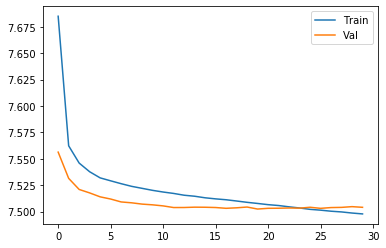

In [50]:
learner.plotLearningCurve()

In [53]:
test_model = RNNModel('gru', ntokens, input_size, hidden_size, nlayers, dropout)
test_model.load_state_dict(torch.load("../checkpoints/seq_3_128_0.7_256_20_best.pt"))
test_model.eval()
generator = Learner(test_model, criterion, optimizer)

In [57]:
generated_seq = learner.generate_seq (100, movie_embeddings, 10)
print("Generated Sequence:")
for id in generated_seq:
    movie = movieData.loc[movieData["MovieID"]==id]
    print(movie.to_string(columns=['Name', 'Genres'], index=False, header=False))

Generated Sequence:
 City Hall (1996)  Drama|Thriller
 Harlem (1993)  Drama
 Mortal Kombat (1995)  Action|Adventure
 Happy Gilmore (1996)  Comedy
 Home for the Holidays (1995)  Drama
 Schizopolis (1996)  Comedy
 Life of �mile Zola, The (1937)  Drama
 Cape Fear (1962)  Film-Noir|Thriller
 Little Buddha (1993)  Drama
 Sister Act (1992)  Comedy|Crime
 Kids of the Round Table (1995)  Adventure|Children's|Fantasy


In [ ]:
test_loss = learner.evaluate(test_data_final, test_tgt_final, ntokens, test_batch_size)
print("Test Loss: ", test_loss)

In [ ]:
from data_preparation import MovieEncodingEmbedding

MovieEncodingEmbedding(29, movieData, genreList, glove_model, vocab)